# MNIST classification, a graph approach
## Set up

In [2]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

#ignore specif warnings
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter("ignore", category=ConvergenceWarning)


# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [3]:
from graphdatascience import GraphDataScience

# Use Neo4j URI and credentials according to your setup
gds = GraphDataScience("bolt://localhost:7687", auth=("neo4j", "pierre"))

print(gds.version())

2.0.1


## Loading the data

In [4]:
from six.moves import urllib
from scipy.io import loadmat

mnist_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
mnist_path = "./mnist-original.mat"
response = urllib.request.urlopen(mnist_url)
with open(mnist_path, "wb") as f:
    content = response.read()
    f.write(content)
mnist_raw = loadmat(mnist_path)
mnist = {
    "data": mnist_raw["data"].T,
    "target": mnist_raw["label"][0],
    "COL_NAMES": ["label", "data"],
    "DESCR": "mldata.org dataset: mnist-original",
}
print("Success!")

Success!


## Exploration

In [13]:
len(mnist['target'])

70000

In [16]:
mnist['data'][12]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,  68, 254, 255, 254,
       107,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,  11, 176, 230, 253,
       253, 253, 212,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  28, 19

In [17]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [40]:
some_digit = X[32100]
some_digit

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

Saving figure some_digit_plot


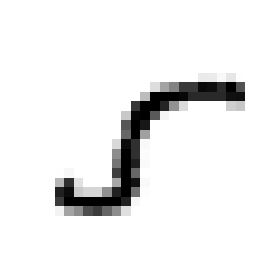

In [42]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

## To black and white

Saving figure some_digit_plot


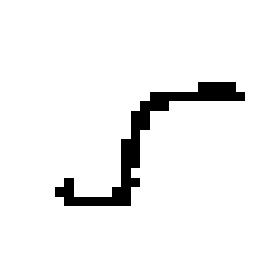

In [41]:
# From grey levels to B&W
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit_image = np.reshape([1 if px > 200 else 0 for px in some_digit],(28, 28))
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [68]:
# writing to file

cpt = 0
with open("MNIST_bandw.txt", "w") as filout:
    for pos, digit in enumerate(X):
        mat = digit.reshape(28, 28)
        black_pixels = []
        for i in range(28):
            for j in range(28):
                if mat[i][j] > 200:
                    black_pixels.append((i,j))
        filout.write(str(black_pixels)+'|'+str(int(y[pos]))+'\n')

### loading to Neo4j

```cypher
CREATE CONSTRAINT darkpixel_x_y IF NOT EXISTS
FOR (px:DarkPixel) REQUIRE (px.x, px.y) IS NODE KEY;
CREATE INDEX darkpixel_x_y_index IF NOT EXISTS
FOR (px:DarkPixel) ON (px.x, px.y);

CREATE CONSTRAINT digit_id IF NOT EXISTS
FOR (px:DarkPixel) REQUIRE (px.x, px.y) IS NODE KEY;
CREATE INDEX digit_id_index IF NOT EXISTS
FOR (px:DarkPixel) ON (px.x, px.y);

// CREATE Pixel Matrix
FOREACH (col_no IN range(0, 27) |
    FOREACH (line_no IN range(0, 27) |
        CREATE (:DarkPixel {x: col_no, y: line_no})
    )
);

MATCH (left:DarkPixel), (right:DarkPixel)
WHERE left.y = right.y
AND left.x + 1 = right.x
MERGE (left)-[:VERTICAL]->(right);

MATCH (up:DarkPixel), (down:DarkPixel)
WHERE up.x = down.x
AND up.y + 1 = down.y
MERGE (up)-[:HORIZONTAL]->(down);

MATCH (nw:DarkPixel), (se:DarkPixel)
WHERE nw.x + 1 = se.x
AND nw.y + 1 = se.y
MERGE (nw)-[:DIAGONAL]->(se);

MATCH (ne:DarkPixel), (sw:DarkPixel)
WHERE ne.x - 1 = sw.x
AND ne.y + 1 = sw.y
MERGE (ne)-[:ANTI_DIAGONAL]->(sw);

// LOAD MNIST
CALL apoc.periodic.iterate("LOAD CSV
FROM 'https://drive.google.com/uc?export=download&id=1zbBjq_-jnunJq3-_2meYPBWTM-KM8UNK' AS row
FIELDTERMINATOR '|'
WITH [c IN split(substring(row[0],2,size(row[0])-4),\"), (\") | split(c, ', ') ] AS vals, toInteger(row[1]) AS y, linenumber() AS id
WITH [c IN vals | {x:toInteger(c[0]), y:toInteger(c[1])}] as vals, y, linenumber() AS id
RETURN vals, y, toInteger(id) - 1 AS id", // 0-based in original dataset
"MERGE (d:Digit {id: id})
WITH vals, y, id, d
CALL apoc.create.setLabels(d, ['Class_'+y, 'Digit'])
YIELD node
WITH vals, y, id, d
UNWIND vals AS px
MATCH (px_node:DarkPixel {x:px.x, y:px.y})
MERGE (d)-[:HAS_DARK_PIXEL]->(px_node)",
{batchSize: 1000, parallel:false});
```



## Show some random digit in bloom
Looks like a 4
![](files/images/classification/bloom_digit_4.png)

### cypher community detection pipeline

#### FastRP embedding | KNN similarity | Louvain community detection 


##### clean up
```cypher

CALL gds.graph.list() YIELD graphName
WITH graphName AS graphToDelete
CALL gds.graph.drop(graphToDelete)
YIELD graphName
RETURN graphName + " deleted";

MATCH ()-[r:SIMILAR]->()
DELETE r;
// FEATURE ENGINEERING
// Project In memory to FAST RP
CALL gds.graph.project(
  'digits',
  ['Digit','DarkPixel'],
  {
    HORIZONTAL: {
      orientation: 'UNDIRECTED'
    },
    VERTICAL: {
      orientation: 'UNDIRECTED'
    },
    DIAGONAL: {
      orientation: 'UNDIRECTED'
    },
    ANTI_DIAGONAL: {
      orientation: 'UNDIRECTED'
    },
    HAS_DARK_PIXEL: {
      orientation: 'NATURAL'
    }
  }
);
```
##### FastRP embedding
```cypher

// FAST RP approx 200 ms
CALL gds.fastRP.mutate('digits',
  {
    embeddingDimension: 30,
    randomSeed: 42,
    mutateProperty: 'embedding',
    iterationWeights: [0.8, 1, 1, 1]
  }
)
YIELD nodePropertiesWritten;

// Filter for KNN SIMILARITY
CALL gds.beta.graph.project.subgraph(
  'digits_only',
  'digits',
  'n:Digit',
  '*'
)
YIELD graphName, fromGraphName, nodeCount, relationshipCount;

CALL gds.graph.writeNodeProperties('digits_only', ['embedding'])
YIELD propertiesWritten;

```
##### KNN similarity
```cypher
                                                                                            
// KNN simN 20s
CALL gds.knn.write('digits_only', {
    topK: 3,
    nodeProperties: ['embedding'],
    randomSeed: 42,
    concurrency: 1,
    sampleRate: 1.0,
    deltaThreshold: 0.0,
    writeRelationshipType: "SIMILAR",
    writeProperty: "score"
})
YIELD nodesCompared, relationshipsWritten, similarityDistribution
RETURN nodesCompared, relationshipsWritten, similarityDistribution.mean as meanSimilarity;

```
##### Louvain community detection
```cypher
      
// Louvain community detection
CALL gds.graph.project(
  'digits_only_emmbedding',
  ['Digit'],
  {
    SIMILAR: {
      orientation: 'UNDIRECTED'
    }
  },
  {
    relationshipProperties: 'score'
  }
);

CALL gds.louvain.write('digits_only_emmbedding', { writeProperty: 'community' })
YIELD communityCount, modularity, modularities;

                                   
```
##### Testing
```cypher
    
// testing query
MATCH (d:Digit)
WITH apoc.coll.flatten(collect([l IN labels(d) WHERE l <> 'Digit'])) AS labels, d.community AS community
WITH apoc.coll.frequencies(labels) AS labels, size(labels) AS community_size,  community
WITH apoc.map.fromLists([x IN labels | x.item],[x IN labels | x.count]) AS labels, community_size,  community
WITH [dig_cls IN range(0, 9) | coalesce(labels['Class_'+dig_cls], 0) ] AS labels, community_size,  community
WITH labels, community_size,  community
RETURN labels, community_size, community;

// testing post-python wrangling
MATCH (d:Digit)
WHERE "Class_"+d.prediction1 IN labels(d)
OR "Class_"+d.prediction2 IN labels(d)
RETURN count(d)/70000.0
```

### Wrangle communities to make predictions

In [468]:
labels_community = gds.run_cypher(
  """
MATCH (d:Digit)
WITH apoc.coll.flatten(collect([l IN labels(d) WHERE l <> 'Digit'])) AS labels, d.community AS community
WITH apoc.coll.frequencies(labels) AS labels, size(labels) AS community_size,  community
WITH apoc.map.fromLists([x IN labels | x.item],[x IN labels | x.count]) AS labels, community_size,  community
WITH [dig_cls IN range(0, 9) | coalesce(labels['Class_'+dig_cls], 0) ] AS labels, community_size,  community
WITH labels, community_size,  community
RETURN labels, community_size, community
  """
)
labels_community

,labels,community_size,community
0,"[5, 2, 34, 11, 2163, 25, 14, 37, 25, 270]",2586,15751
1,"[4, 2, 27, 5, 2459, 29, 24, 29, 123, 90]",2792,53166
2,"[56, 76, 188, 332, 105, 283, 74, 77, 4754, 115]",6060,40684
3,"[16, 10, 40, 121, 320, 49, 15, 233, 202, 1633]",2639,47142
4,"[3, 22, 39, 54, 736, 84, 15, 317, 123, 2064]",3457,45886
5,"[2853, 3, 71, 85, 22, 104, 114, 14, 20, 28]",3314,62007
6,"[12, 7, 39, 53, 28, 18, 0, 2753, 14, 198]",3122,33650
7,"[16, 7, 35, 69, 468, 58, 7, 171, 153, 2038]",3022,46265
8,"[69, 18, 100, 25, 56, 142, 1913, 8, 86, 5]",2422,29226
9,"[63, 0, 67, 17, 186, 82, 4432, 12, 82, 33]",4974,26219


In [186]:
labels_community.labels

0           [5, 2, 34, 11, 2163, 25, 14, 37, 25, 270]
1            [4, 2, 27, 5, 2459, 29, 24, 29, 123, 90]
2     [56, 76, 188, 332, 105, 283, 74, 77, 4754, 115]
3      [16, 10, 40, 121, 320, 49, 15, 233, 202, 1633]
4        [3, 22, 39, 54, 736, 84, 15, 317, 123, 2064]
5         [2853, 3, 71, 85, 22, 104, 114, 14, 20, 28]
6           [12, 7, 39, 53, 28, 18, 0, 2753, 14, 198]
7         [16, 7, 35, 69, 468, 58, 7, 171, 153, 2038]
8          [69, 18, 100, 25, 56, 142, 1913, 8, 86, 5]
9          [63, 0, 67, 17, 186, 82, 4432, 12, 82, 33]
10          [6, 16, 96, 72, 33, 11, 2, 3256, 70, 178]
11        [11, 28, 2068, 79, 21, 13, 14, 30, 106, 13]
12         [18, 3057, 87, 36, 33, 38, 27, 102, 85, 6]
13       [66, 3, 38, 1573, 35, 1625, 48, 25, 401, 94]
14           [2, 2852, 54, 52, 23, 24, 8, 45, 58, 27]
15         [32, 19, 3811, 77, 61, 17, 20, 54, 42, 19]
16          [32, 2, 7, 196, 18, 2260, 69, 7, 118, 41]
17             [25, 4, 7, 18, 12, 1112, 14, 3, 51, 6]
18          [0, 1738, 37, 35

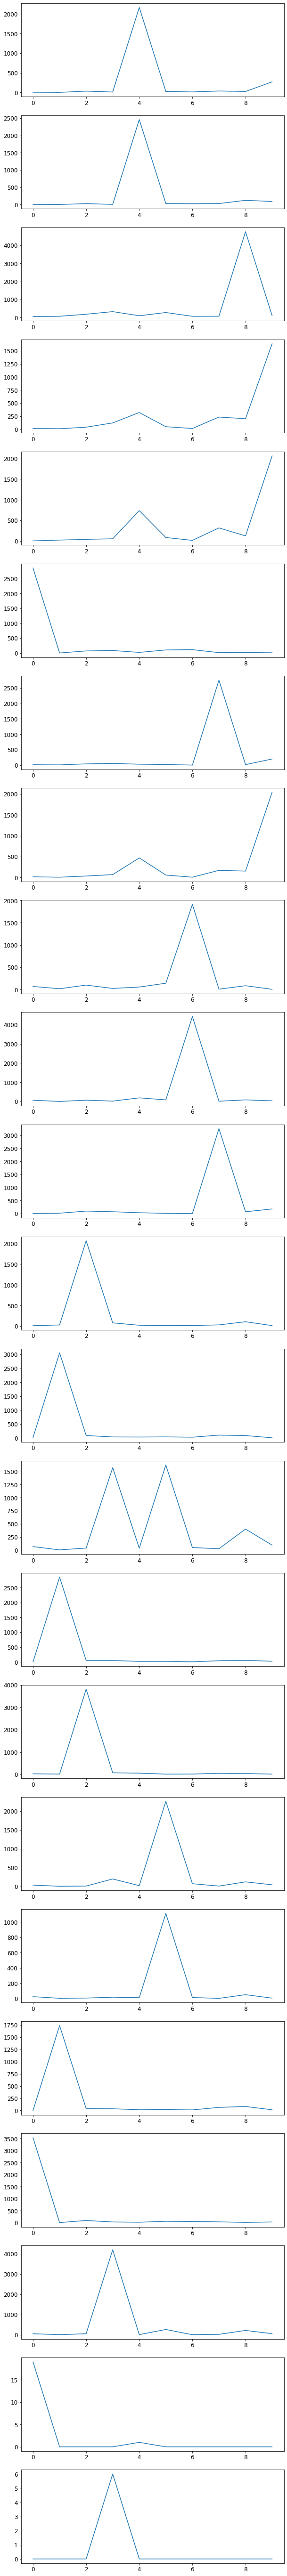

In [187]:
fig, axs = plt.subplots(len(labels_community),figsize=(10,100))
for i in range(len(labels_community)):
    axs[i].plot(list(range(10)), labels_community.labels[i])


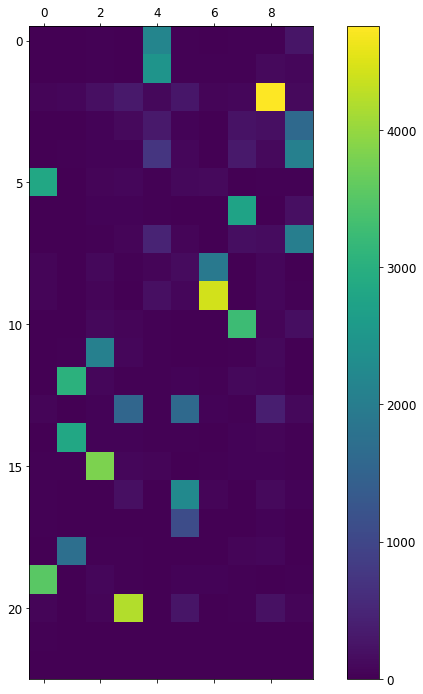

In [188]:
def plot_confusion_matrix(matrix):
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

plot_confusion_matrix([labels_community.labels[i] for i in range(len(labels_community))])

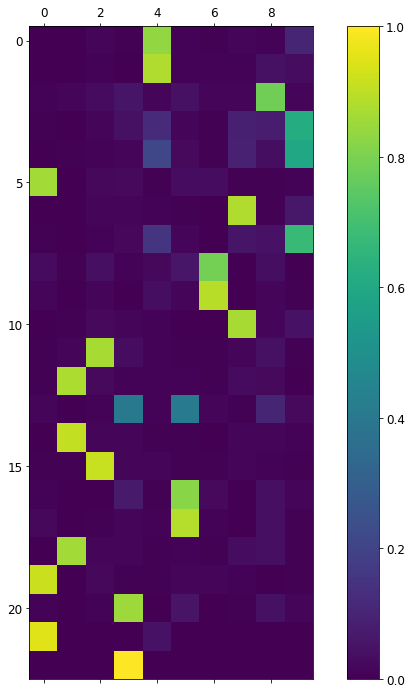

In [189]:
# NORMALIZED MATRIX
normalized_comm_freq = [[freq/labels_community.community_size[i] for freq in labels_community.labels[i]] for i in range(len(labels_community))]
plot_confusion_matrix(normalized_comm_freq)

In [209]:
labels_community['prediction'] = labels_community.labels.map(
    lambda X: [ (k,x) for k, x in enumerate(X)]).map(
    lambda X : sorted(X,key=lambda x:x[1], reverse= True)).map(
    lambda X : [x[0] for x in X[:2]])
labels_community['prediction'] # best two predictions

0     [4, 9]
1     [4, 8]
2     [8, 3]
3     [9, 4]
4     [9, 4]
5     [0, 6]
6     [7, 9]
7     [9, 4]
8     [6, 5]
9     [6, 4]
10    [7, 9]
11    [2, 8]
12    [1, 7]
13    [5, 3]
14    [1, 8]
15    [2, 3]
16    [5, 3]
17    [5, 8]
18    [1, 8]
19    [0, 2]
20    [3, 5]
21    [0, 4]
22    [3, 0]
Name: prediction, dtype: object

In [210]:
labels_community

,labels,community_size,community,prediction
0,"[5, 2, 34, 11, 2163, 25, 14, 37, 25, 270]",2586,15751,"[4, 9]"
1,"[4, 2, 27, 5, 2459, 29, 24, 29, 123, 90]",2792,53166,"[4, 8]"
2,"[56, 76, 188, 332, 105, 283, 74, 77, 4754, 115]",6060,40684,"[8, 3]"
3,"[16, 10, 40, 121, 320, 49, 15, 233, 202, 1633]",2639,47142,"[9, 4]"
4,"[3, 22, 39, 54, 736, 84, 15, 317, 123, 2064]",3457,45886,"[9, 4]"
5,"[2853, 3, 71, 85, 22, 104, 114, 14, 20, 28]",3314,62007,"[0, 6]"
6,"[12, 7, 39, 53, 28, 18, 0, 2753, 14, 198]",3122,33650,"[7, 9]"
7,"[16, 7, 35, 69, 468, 58, 7, 171, 153, 2038]",3022,46265,"[9, 4]"
8,"[69, 18, 100, 25, 56, 142, 1913, 8, 86, 5]",2422,29226,"[6, 5]"
9,"[63, 0, 67, 17, 186, 82, 4432, 12, 82, 33]",4974,26219,"[6, 4]"


#### Communities 2 most frequent digits

In [211]:
comm_pred = [(labels_community.community[i], labels_community.prediction[i]) for i in range(len(labels_community))]
comm_pred

[(15751, [4, 9]),
 (53166, [4, 8]),
 (40684, [8, 3]),
 (47142, [9, 4]),
 (45886, [9, 4]),
 (62007, [0, 6]),
 (33650, [7, 9]),
 (46265, [9, 4]),
 (29226, [6, 5]),
 (26219, [6, 4]),
 (32601, [7, 9]),
 (3760, [2, 8]),
 (69854, [1, 7]),
 (10716, [5, 3]),
 (69797, [1, 8]),
 (6316, [2, 3]),
 (20318, [5, 3]),
 (23998, [5, 8]),
 (49510, [1, 8]),
 (59114, [0, 2]),
 (10178, [3, 5]),
 (48995, [0, 4]),
 (8658, [3, 0])]

In [470]:
predict_queries = ["MATCH (d:Digit {{community: {}}})\nSET d.prediction1 = {}\nSET d.prediction2 = {}"
           .format(comm, pred[0], pred[1]) for comm, pred in comm_pred]
print(predict_queries)

['MATCH (d:Digit {community: 15751})\nSET d.prediction1 = 4\nSET d.prediction2 = 9', 'MATCH (d:Digit {community: 53166})\nSET d.prediction1 = 4\nSET d.prediction2 = 8', 'MATCH (d:Digit {community: 40684})\nSET d.prediction1 = 8\nSET d.prediction2 = 3', 'MATCH (d:Digit {community: 47142})\nSET d.prediction1 = 9\nSET d.prediction2 = 4', 'MATCH (d:Digit {community: 45886})\nSET d.prediction1 = 9\nSET d.prediction2 = 4', 'MATCH (d:Digit {community: 62007})\nSET d.prediction1 = 0\nSET d.prediction2 = 6', 'MATCH (d:Digit {community: 33650})\nSET d.prediction1 = 7\nSET d.prediction2 = 9', 'MATCH (d:Digit {community: 46265})\nSET d.prediction1 = 9\nSET d.prediction2 = 4', 'MATCH (d:Digit {community: 29226})\nSET d.prediction1 = 6\nSET d.prediction2 = 5', 'MATCH (d:Digit {community: 26219})\nSET d.prediction1 = 6\nSET d.prediction2 = 4', 'MATCH (d:Digit {community: 32601})\nSET d.prediction1 = 7\nSET d.prediction2 = 9', 'MATCH (d:Digit {community: 3760})\nSET d.prediction1 = 2\nSET d.prediction

In [213]:
for q in predict_queries:
    gds.run_cypher(q)

In [475]:
gds.run_cypher("""
MATCH (d:Digit)
WHERE "Class_"+d.prediction1 IN labels(d)
RETURN count(d)/70000.0 AS accuracy
""")

,accuracy
0,0.808614


In [474]:
gds.run_cypher("""
MATCH (d:Digit)
WHERE "Class_"+d.prediction1 IN labels(d)
OR "Class_"+d.prediction2 IN labels(d)
RETURN count(d)/70000.0 AS accuracy
""")

,accuracy
0,0.889586


## Scikit learn + Embedding aproach

In [404]:
## USING EMBEDDING
mnist_graph_embedding_q = gds.run_cypher("""
MATCH (d:Digit)
RETURN d.id AS id, labels(d) AS label, d.embedding AS embedding
ORDER BY id
""")

In [405]:
mnist_graph_embedding = mnist_graph_embedding_q

In [406]:
mnist_graph_embedding

,id,label,embedding
0,0,"[Digit, Class_0]","[0.2700386643409729, 0.3618219196796417, -0.37..."
1,1,"[Digit, Class_0]","[0.1603020876646042, 0.1621115356683731, -0.25..."
2,2,"[Digit, Class_0]","[0.0884307324886322, -0.07725483924150467, 0.0..."
3,3,"[Digit, Class_0]","[0.16218401491641998, 0.14951293170452118, -0...."
4,4,"[Digit, Class_0]","[0.5642150640487671, -0.29365599155426025, -0...."
...,...,...,...
69995,69995,"[Digit, Class_9]","[0.7827990055084229, -0.239018052816391, -0.38..."
69996,69996,"[Digit, Class_9]","[0.1741989254951477, 0.1532590091228485, -0.84..."
69997,69997,"[Digit, Class_9]","[0.9170995950698853, 0.007505547255277634, 0.0..."
69998,69998,"[Digit, Class_9]","[0.8380705714225769, 0.19315870106220245, 0.51..."


In [407]:
mnist_graph_embedding.label = mnist_graph_embedding_q.label.map(lambda X: int([x for x in X if x != "Digit"][0][-1]))

In [408]:
mnist_graph_embedding.embedding.map(lambda X: [x for x in X])

0        [0.2700386643409729, 0.3618219196796417, -0.37...
1        [0.1603020876646042, 0.1621115356683731, -0.25...
2        [0.0884307324886322, -0.07725483924150467, 0.0...
3        [0.16218401491641998, 0.14951293170452118, -0....
4        [0.5642150640487671, -0.29365599155426025, -0....
                               ...                        
69995    [0.7827990055084229, -0.239018052816391, -0.38...
69996    [0.1741989254951477, 0.1532590091228485, -0.84...
69997    [0.9170995950698853, 0.007505547255277634, 0.0...
69998    [0.8380705714225769, 0.19315870106220245, 0.51...
69999    [0.7230238318443298, 0.06831254065036774, -0.6...
Name: embedding, Length: 70000, dtype: object

In [409]:
embedding = np.array([x for x in mnist_graph_embedding.embedding.map(lambda X: [x for x in X])])
embedding

array([[ 0.27003866,  0.36182192, -0.37930793, ..., -0.09671639,
         1.23425496, -0.27815768],
       [ 0.16030209,  0.16211154, -0.25199237, ...,  0.09622888,
         0.98618788,  0.19670133],
       [ 0.08843073, -0.07725484,  0.05296512, ..., -0.51351333,
         1.75974727, -0.65944314],
       ...,
       [ 0.9170996 ,  0.00750555,  0.05752566, ..., -1.08006012,
         0.56751025, -0.35670394],
       [ 0.83807057,  0.1931587 ,  0.51606619, ..., -1.12570715,
         0.95692122, -0.29762208],
       [ 0.72302383,  0.06831254, -0.63724256, ..., -1.11427212,
         0.65769327, -0.38879889]])

In [410]:
label = np.array(mnist_graph_embedding.label)

X_train, X_test, y_train, y_test = embedding[:60000], embedding[60000:], label[:60000], label[60000:]

In [411]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Binaire 5 or not 5

In [412]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [413]:
X_train[:12]

array([[ 5.01576304e-01, -5.64735651e-01, -1.09952927e-01,
        -7.96843991e-02,  2.06666589e-02, -3.82583916e-01,
        -3.49284202e-01,  1.63655877e+00, -6.21281445e-01,
         2.42415279e-01,  4.85655665e-01,  9.98674512e-01,
        -1.20547271e+00,  7.53431320e-01, -6.40916228e-01,
         1.03607528e-01, -9.50381830e-02,  3.29234526e-02,
        -3.33885491e-01, -1.48031518e-01,  2.37061262e-01,
         8.17777574e-01, -5.82813501e-01, -5.43771744e-01,
         4.51287687e-01,  7.91764408e-02, -4.43873823e-01,
        -1.11138678e+00,  1.63401175e+00,  7.92235285e-02],
       [ 8.78171444e-01, -5.08995280e-02,  1.71069130e-02,
         2.74332464e-01,  6.27151310e-01, -8.19636464e-01,
         2.05858037e-01,  1.51641130e+00, -6.72680378e-01,
         2.10823759e-01,  6.43610597e-01,  3.38034838e-01,
        -2.36205459e-01,  4.92238432e-01, -5.62934697e-01,
        -4.25911918e-02,  7.30627060e-01, -6.35729134e-01,
         2.86950380e-01,  4.64173794e-01,  1.05962276e+

### SGDC

In [414]:
from sklearn.linear_model import SGDClassifier # stochastic gradient descent 

sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(max_iter=5, random_state=42)

In [418]:
sgd_clf.predict([embedding[36000]])

array([ True])

In [421]:
# ⨯-val avec scikit-learn
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.941 , 0.9414, 0.9407])

In [422]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

### stochastic gradient descent confusion matrix

In [423]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53656,   923],
       [ 2615,  2806]])

In [424]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.7524805577902923

In [425]:
recall_score(y_train_5, y_train_pred)

0.5176166758900572

In [426]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.6133333333333334

## random forest

In [429]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42, n_estimators=10)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [430]:
y_probas_forest

array([[1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       ...,
       [0.9, 0.1],
       [1. , 0. ],
       [1. , 0. ]])

In [440]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

Saving figure roc_curve_comparison_plot


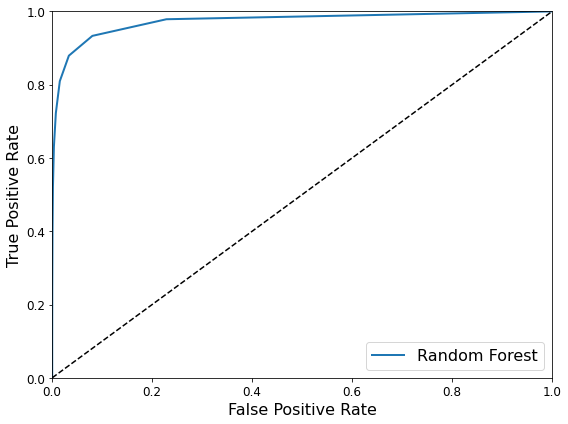

In [443]:
plt.figure(figsize=(8, 6))
#plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [445]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores_forest)

0.973140624615597

## 10-digit Classification

In [452]:
forest_clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=42)

In [617]:
some_digit_index = 69223
some_digit = embedding[some_digit_index]
some_image = mnist["data"][some_digit_index]
forest_clf.predict([some_digit])

array([9])

Saving figure some_digit_plot


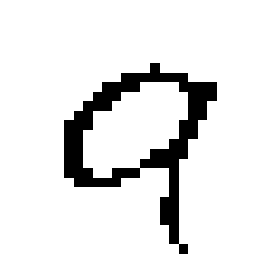

In [618]:
# From grey levels to B&W
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit_image = np.reshape([1 if px > 200 else 0 for px in some_image],(28, 28))
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [619]:
import networkx as nx
G = nx.Graph()
pxs = gds.run_cypher("MATCH (d:Digit {{id: {}}})-[:HAS_DARK_PIXEL]-(px:DarkPixel) RETURN px.x AS x, px.y AS y".format(some_digit_index))

pixels = [(px[1][1], 28-px[1][0]) for px in pxs.iterrows()]
print(pixels)
#G.add_nodes_from(pixels)
#G.add_nodes_from([(1000, {"x":0, "y":0, "color": "red"})])
#for px in pixels:
#    G.add_edge(1000, px[0])

#pos = {point: point for point in pxs}

[(19, 16), (17, 10), (16, 8), (20, 17), (21, 19), (10, 19), (20, 20), (17, 13), (17, 12), (18, 3), (6, 13), (19, 18), (16, 13), (13, 20), (10, 10), (10, 18), (18, 15), (19, 17), (17, 7), (19, 15), (7, 13), (7, 16), (9, 19), (21, 20), (18, 14), (7, 17), (6, 16), (9, 10), (7, 10), (16, 21), (8, 16), (7, 11), (17, 9), (17, 6), (10, 20), (15, 21), (17, 4), (18, 13), (11, 11), (6, 14), (18, 16), (20, 18), (14, 12), (19, 20), (15, 13), (16, 12), (7, 14), (17, 21), (11, 20), (8, 11), (17, 8), (7, 15), (12, 21), (14, 21), (13, 21), (15, 12), (9, 18), (19, 19), (15, 22), (8, 17), (16, 6), (12, 20), (6, 15), (18, 20), (8, 10), (6, 12), (13, 11), (11, 19), (6, 11), (11, 10), (17, 14), (16, 7), (8, 18), (12, 11), (20, 19), (18, 21), (17, 11), (7, 12), (17, 5)]


[(0, 0), (19, 16), (17, 10), (16, 8), (20, 17), (21, 19), (10, 19), (20, 20), (17, 13), (17, 12), (18, 3), (6, 13), (19, 18), (16, 13), (13, 20), (10, 10), (10, 18), (18, 15), (19, 17), (17, 7), (19, 15), (7, 13), (7, 16), (9, 19), (21, 20), (18, 14), (7, 17), (6, 16), (9, 10), (7, 10), (16, 21), (8, 16), (7, 11), (17, 9), (17, 6), (10, 20), (15, 21), (17, 4), (18, 13), (11, 11), (6, 14), (18, 16), (20, 18), (14, 12), (19, 20), (15, 13), (16, 12), (7, 14), (17, 21), (11, 20), (8, 11), (17, 8), (7, 15), (12, 21), (14, 21), (13, 21), (15, 12), (9, 18), (19, 19), (15, 22), (8, 17), (16, 6), (12, 20), (6, 15), (18, 20), (8, 10), (6, 12), (13, 11), (11, 19), (6, 11), (11, 10), (17, 14), (16, 7), (8, 18), (12, 11), (20, 19), (18, 21), (17, 11), (7, 12), (17, 5)]
[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27)

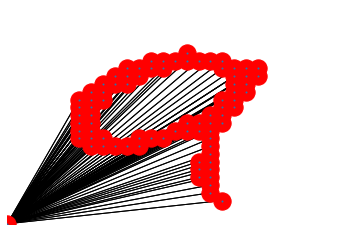

In [620]:
import networkx as nx
import matplotlib.pyplot as plt


def add_edge_to_graph(G, e1, e2, w):
    G.add_edge(e1, e2, weight=w)


G = nx.Graph()
points = [(0,0)] + pixels  # (x,y) points
edges = [(0,i+1) for i, _ in enumerate(pixels)]  # (v1,v2, weight)
print(points)
print(edges)

for i in range(len(edges)):
    add_edge_to_graph(G, points[edges[i][0]], points[edges[i][1]], "HAS_DARK_PIXEL")

# you want your own layout
# pos = nx.spring_layout(G)
pos = {point: point for point in points}

# add axis
fig, ax = plt.subplots()
nx.draw(G, pos=pos, node_color='r', ax=ax)
nx.draw(G, pos=pos, node_size=1, ax=ax)  # draw nodes and edges
#nx.draw_networkx_labels(G, pos=pos)  # draw node labels/names
# draw edge weights
#labels = nx.get_edge_attributes(G, 'weight')
#nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, ax=ax)
#plt.axis("on")
ax.set_xlim(0, 28)
ax.set_ylim(0,28)
#ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [621]:
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0.1, 0. , 0.1, 0. , 0.1, 0. , 0. , 0.7]])

In [622]:
cross_val_score(forest_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.86365, 0.86305, 0.86515])

In [623]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5353,    1,   94,   72,   19,  136,  123,   27,   51,   47],
       [   1, 5856,  355,   67,   25,   96,   23,   33,  223,   63],
       [  56,   83, 4810,  183,  143,   74,  208,  105,  237,   59],
       [  89,   67,  239, 5037,   28,  298,   59,   81,  143,   90],
       [  10,   16,   97,   48, 4709,  133,  126,   21,  116,  566],
       [ 136,  102,  103,  796,  179, 3567,  222,   36,  149,  131],
       [  83,   31,  139,   39,  249,  167, 5064,    4,   88,   54],
       [ 138,  128,  128,  133,  156,   96,   21, 4809,  142,  514],
       [  34,  223,  143,  496,  184,  399,  108,   87, 3938,  239],
       [  30,   27,   94,  236,  601,  249,   43,  273,  273, 4123]])

Saving figure confusion_matrix_plot


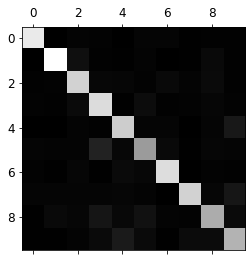

In [624]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

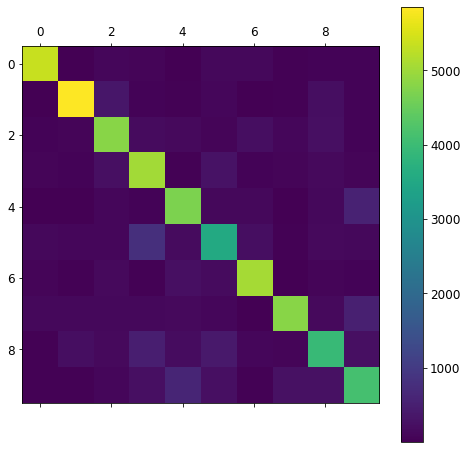

In [625]:
def plot_confusion_matrix(matrix):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

plot_confusion_matrix(conf_mx)